In [1]:
import pandas as pd
import numpy as np
import tqdm
from DecisionTreeClassifier import DTC

In [2]:
import sys
sys.path.append("/Users/fabio/jars")
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkContext
from graphframes import GraphFrame
from pyspark.sql.types import *


spark_driver_memory = "10g"
spark_executor_memory = "6g"



spark = SparkSession.builder \
                    .config("spark.driver.memory", spark_driver_memory) \
                    .config("spark.executor.memory", spark_executor_memory) \
                    .master("local[*]") \
                    .getOrCreate()
spark.sparkContext.setLogLevel('WARN')
print("Spark session created")
sc = spark.sparkContext
print("Spark context created")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/04 18:55:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/04 18:55:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark session created
Spark context created


In [3]:
train_df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("./preprocessed_data/train_small")

In [4]:
train_df = train_df.drop("amount_received").drop("amount_paid").drop("hop_2").drop("hop_3").drop("hop_4").drop("hop_5").drop("hop_6").drop("hop_7").drop("hop_8").drop("hop_9").drop("hop_10").drop("hop_11").drop("hop_12").drop("hop_13").drop("fan_in_degree").drop("fan_out_degree").drop("payment_payment")

In [5]:
train_df.printSchema()

root
 |-- receiving_currency: integer (nullable = true)
 |-- payment_currency: integer (nullable = true)
 |-- payment_format: integer (nullable = true)
 |-- is_laundering: integer (nullable = true)
 |-- same_account: integer (nullable = true)
 |-- same_currency: integer (nullable = true)
 |-- same_bank: integer (nullable = true)
 |-- same_amount: integer (nullable = true)



In [6]:
train_all = np.array(train_df.collect())

In [7]:
X_1 = [i for i,x in enumerate(train_all) if x[3] == 1]
X_0 = [i for i,x in enumerate(train_all) if x[3] == 0]

X = pd.DataFrame([train_all[i] for i in X_1] + [train_all[i] for i in X_0[:len(X_1)]])
X_train = np.array(X.drop(3, axis=1))
y_train = np.array(X.iloc[:,3])

X_t = pd.DataFrame([train_all[i] for i in X_0[len(X_1):]])
x_t = np.array(X_t.drop(3, axis=1))
y_t = np.array(X_t.iloc[:,3])


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
import matplotlib.pyplot as plt
#rf = RandomForestClassifier(random_state=0, class_weight="balanced_subsample")
#rf.fit(X_train, y_train)


clf = DTC()
clf.fit(X_train, y_train)


# Genera la rappresentazione grafica dell'albero decisionale
"""plt.figure(figsize=(40, 30))
tree.plot_tree(clf, feature_names=train_df.columns, class_names=["0","1"], filled=True, rounded=True)
plt.show()"""

'plt.figure(figsize=(40, 30))\ntree.plot_tree(clf, feature_names=train_df.columns, class_names=["0","1"], filled=True, rounded=True)\nplt.show()'

In [9]:
test_df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("./preprocessed_data/validation_small")
test_df = test_df.drop("amount_received").drop("amount_paid").drop("hop_2").drop("hop_3").drop("hop_4").drop("hop_5").drop("hop_6").drop("hop_7").drop("hop_8").drop("hop_9").drop("hop_10").drop("hop_11").drop("hop_12").drop("hop_13").drop("fan_in_degree").drop("fan_out_degree").drop("payment_payment")

In [10]:
# Convert X_test to a 2D array
X_test_array = np.array([list(x.asDict().values()) for x in list(test_df.drop("is_laundering").collect())])
X_t_array = np.array(x_t)

# Concatenate the arrays into a single 2D array
X_test_combined = np.concatenate((X_test_array, X_t_array), axis=0)

# Convert y_test to a 1D array
y_test_array = np.array([x.is_laundering for x in test_df.collect()])
y_t_array = np.array(y_t)

# Concatenate the arrays into a single 1D array
y_test_combined = np.concatenate((y_test_array, y_t_array), axis=0)


In [11]:
#X_test = list(np.array([list(x.asDict().values()) for x in list(test_df.drop("is_laundering").collect())])) + list(x_t)
#y_test =  list(np.array([list(x.asDict().values()) for x in list(test_df.select("is_laundering").collect())])) + list(y_t) 0.7972554504228367

In [12]:
print(clf.score(X_test_combined, y_test_combined))
y_pred = clf.predict(X_test_combined)

{'accuracy': 0.765281187574915, 'recall': 0.0014169748384195654, 'precision': 0.9398998330550918, 'f1_score': 0.0028296837003349883, 'roc_auc': 0.5006945684692554}


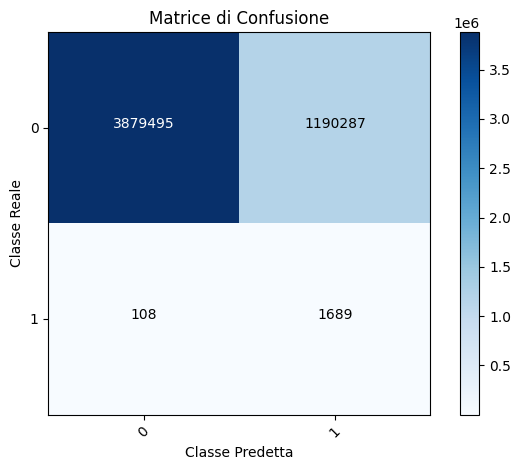

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcola la matrice di confusione
cm = confusion_matrix(y_test_combined, y_pred)

# Etichette delle classi (sostituisci con i tuoi nomi di classi reali se necessario)
class_names = ['0', '1']

# Crea il grafico della matrice di confusione
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice di Confusione')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Aggiungi i valori delle celle nella matrice
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Classe Predetta')
plt.ylabel('Classe Reale')
plt.tight_layout()
plt.show()

# COSTRUCTION OF THE TREE CLASSIFIER OPTIMIZED

In [17]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from DecisionTreeClassifier import DTC
from DC import DecisionTree as dc
data = load_breast_cancer(as_frame=False)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=0.2)

In [24]:
n_samples = len(y_train)
n_positives = sum(y_train)
n_negatives = n_samples - n_positives

class_weight = {0: n_samples / (2 * n_negatives), 1: n_samples / (2 * n_positives)}
"""
{'accuracy': 0.8859649122807017,
 'recall': 0.9402985074626866,
 'precision': 0.875,
 'f1_score': 0.9064748201438849,
 'roc_auc': 0.8744045728802795}"""

In [27]:
clf = DTC(criterion='gini', class_weights = class_weight)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

{'accuracy': 0.8859649122807017,
 'recall': 0.9402985074626866,
 'precision': 0.875,
 'f1_score': 0.9064748201438849,
 'roc_auc': 0.8744045728802795}